
### The University of Melbourne, School of Computing and Information Systems
# COMP30027 Machine Learning, 2020 Semester 1

## Assignment 1: Naive Bayes Classifiers

###### Submission deadline: 7 pm, Monday 20 Apr 2020

**Student Name(s):**    Jiayuan Zhu

**Student ID(s):**     1067734


This iPython notebook is a template which you will use for your Assignment 1 submission.

Marking will be applied on the four functions that are defined in this notebook, and to your responses to the questions at the end of this notebook (Submitted in a separate PDF file).

**NOTE: YOU SHOULD ADD YOUR RESULTS, DIAGRAMS AND IMAGES FROM YOUR OBSERVATIONS IN THIS FILE TO YOUR REPORT (the PDF file).**

You may change the prototypes of these functions, and you may write other functions, according to your requirements. We would appreciate it if the required functions were prominent/easy to find.

**Adding proper comments to your code is MANDATORY. **

In [1]:
import pandas as pd
import numpy as np
from collections import defaultdict
import math
from sklearn.cluster import KMeans
from scipy.cluster.vq import vq
from sklearn import preprocessing
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [2]:
BIN = 3
# Preprocesing: The following is used to prepare the data by converting it into a useful format 
# for training and testing which contains deleting missing values, standardizing numeric variables, 
# discretizing numeric variables by kmeans or equal-width or equal-frequency
def prework(file_name, delete_ID, mark, method, standard):
    return_new = False
    
    # Get rid of missing values
    if mark != None:
        index = []
        # Find the row index of missing value
        for i in range(file_name.shape[1]):
            for j in range(file_name.shape[0]):
                if file_name.iloc[j,i] in mark and j not in index:
                    index.append(j)
        # Delete the row according to the index
        file_name = file_name.drop(index)
       
    # Get rid of ID number
    if delete_ID == True:
        file_name = file_name.iloc[:,1:]
        
    # Standardize numeric variables
    if standard == True:
        label = pd.Series(list(file_name.iloc[:,0]))
        file_rest = preprocessing.StandardScaler().fit_transform(pd.DataFrame(file_name.iloc[:,1:]))
        file_name = pd.DataFrame(file_rest)
        file_name = pd.concat([label, file_name], axis = 1)
    
    # Constructe new dataset by discretizing the varibles with K-mean method
    new_csv = pd.DataFrame(file_name.iloc[:,0])
    if method == 'kmeans':
        return_new = True
        # Apply kmeans to each attribute
        for i in range(1, file_name.shape[1]):
            kmeans = KMeans(n_clusters = BIN).fit((file_name.iloc[:,i].values).reshape(-1,1))
            centroids = kmeans.cluster_centers_
            idx,_ = vq((file_name.iloc[:,i].values).reshape(-1,1), centroids)
            new_csv[i+1] = idx
               
    # Constructe new dataset by discretizing the varibles with equal-width method    
    if method == 'equal width': 
        return_new = True
        for i in range(1, file_name.shape[1]):
            label_list = []
            # Find the range and hence to find cut-off points
            whole_range = max(file_name.iloc[:,i]) - min(file_name.iloc[:,i])
            dividen = whole_range / BIN
            for j in range(file_name.shape[0]):
                if min(file_name.iloc[:,i]) <= file_name.iloc[j,i] < min(file_name.iloc[:,i]) + dividen:
                    label_list.append(0)
                elif min(file_name.iloc[:,i]) + dividen <= file_name.iloc[j,i] < min(file_name.iloc[:,i]) + 2 * dividen:
                    label_list.append(1)
                else:
                    label_list.append(2)
            # New column for the new dataset
            new_csv[i+1] = label_list         
    
    # Constructe new dataset by discretizing the varibles with equal-frequency method
    if method == 'equal frequency':
        return_new = True
        for i in range(1, file_name.shape[1]):
            # Find the ordered list and hence to find cut-off points
            order_list = sorted(file_name.iloc[:,i])
            number = len(order_list)
            cut1 = order_list[int(number / BIN) - 1]
            cut2 = order_list[int(number * 2 / BIN) - 1]
            label_list = []
            for j in range(file_name.shape[0]):
                if order_list[0] <= file_name.iloc[j,i] <= cut1:
                    label_list.append(0)
                elif cut1 < file_name.iloc[j,i] <= cut2:
                    label_list.append(1)
                else:
                    label_list.append(2)
            # New column for the new dataset
            new_csv[i+1] = label_list

    # Return the csv file after preprocessing
    if return_new == True:
        return new_csv
    else:
        return file_name  

In [3]:
# Training and testing data splitting: The following functions maybe used to seperate training and testing data
# 1. Function to seperate training set from whole dataset
def find_train(file_name, x_train_number):
    x_train = pd.DataFrame()
    for number in x_train_number:
        x_train[number] = file_name.iloc[number,:]
    x_train = x_train.transpose()
    return x_train

# 2. Function to seperate testing set from whole dataset
def find_test(file_name, x_train_number):
    # Find index for testing set
    x_test_number = []
    for i in range(file_name.shape[0]):
        if i not in x_train_number:
            x_test_number.append(i)
            
    # Generate testing set
    x_test = pd.DataFrame()
    for number in x_test_number:
        x_test[number] = file_name.iloc[number,:]
    x_test = x_test.transpose()
    return x_test

In [4]:
# Calculates prior probabilities and likelihoods from the training data and using them to build a naive Bayes 
# model (Gaussian Naive Bayes model and Naive Bayes model for discrete variables)
def train(x_train, class_dict, datatype):
    # Train Gaussian Naive Bayes model
    # Find the dictionary (keys are class label)composed by another dictionary (keys are attributes of original 
    # dataset) composed by integers (keys are average value and standard derivation of training set)
    if datatype == 'numeric':
        mean_all = {}
        sd_all = {}
        # Find entities with same class label
        grouped = x_train.groupby(x_train.iloc[:,0])
        for k, group in grouped:
            group = group.iloc[:,1:]

            # Find mean and standard derivation for each attribute
            mean_all[k] = list(group.mean())
            sd_all[k] = list(group.std())

        # Construct the dictionary composed by another dictionary composed by integers    
        new_class_dict = defaultdict(dict)
        for i in range (x_train.shape[1] - 1):
            cluster_dict = defaultdict(dict)
            for element in list(class_dict.keys()):
                inner_dict = defaultdict(int) 
                inner_dict['mu'] = mean_all[element][i]
                inner_dict['sd'] = sd_all[element][i]
                cluster_dict[element] = inner_dict
            new_class_dict[i+1] = cluster_dict
        return new_class_dict
    
    # Train naive Bayes model with discrete varibales
    # Find the dictionary (keys are class label)composed by another dictionary (keys are attributes of original 
    # dataset) composed by integers (keys are different groups under the attribute)
    else:
        # Find entities with same class label
        grouped = x_train.groupby(x_train.iloc[:,0])
        new_class_dict = defaultdict(dict)

        # Construct the dictionary composed by another dictionary composed by integers    
        for i in range(1, x_train.shape[1]):
            cluster_dict = defaultdict(dict)
            keylist= set()
            for k, group in grouped:
                inner_dict = defaultdict(int)
                for element in group.iloc[:,i]:
                    inner_dict[element] += 1
                    keylist.add(element)
                cluster_dict[k] = inner_dict
            cluster_dict['keylist'] = keylist
            new_class_dict[i] = cluster_dict
        return new_class_dict

In [5]:
# This function predicts classes for new items in a test dataset
# Assign extreme value to avoid underflow
EXTREME = -1000
def predict(labellist, x_test_numeric, x_test_discrete, class_dict, new_class_dict, dictionary, k):
    
    # Intialize predict label list
    label_predict = []
    
    for i in range(labellist.shape[0]):
        
        # Construct the dictionary to store the prior (P(cj)) and use log transformation to avoid underflow
        prob_total = defaultdict(int)
        for key in class_dict.keys():
            prob_total[key] = math.log(class_dict[key] / sum(class_dict.values()))
        
        # Gaussian Naive Bayes model prediction for numeric variables
        if x_test_numeric.shape[1] > 0:
            for j in range(x_test_numeric.shape[1]):
                x = x_test_numeric.iloc[i,j]
                prob_current = defaultdict(int)

                # Construct the dictionary to store the likelihood P(X=x|cj)
                for key in class_dict.keys():
                    mu_current = new_class_dict[j+1][key]['mu']
                    sd_current = new_class_dict[j+1][key]['sd']
                    prob_current[key] = 1/(sd_current*math.sqrt(2 * math.pi)) * math.exp(
                        -0.5 * (((x - mu_current)/sd_current)**2))               
                    if prob_current[key] > 0:
                        prob_total[key] += math.log(prob_current[key])
                    else:
                        prob_total[key] += EXTREME
        
        # Naive Bayes model prediction for discrete variables
        if x_test_discrete.shape[1] > 0:
            for j in range(x_test_discrete.shape[1]):
                prob_current = defaultdict(int)
                x = x_test_discrete.iloc[i,j]
                
                # Construct the dictionary to store the likelihood P(X=x|cj) with Laplace smoothing
                for key in class_dict.keys():
                    if x in dictionary[j+1][key].keys():
                        prob_current[key] = (dictionary[j+1][key][x] + k) / (class_dict[key] + 
                                                                             k * len(dictionary[j+1]['keylist']))
                    else:
                        prob_current[key] = k / (class_dict[key] + k * len(dictionary[j+1]['keylist']))
                    if prob_current[key] > 0:
                        prob_total[key] += math.log(prob_current[key]) 
                    else:
                        prob_total[key] += EXTREME
        
        # Find the value of maximum probability and the corresponding label
        max_prob = max(prob_total.values())  
        for key in class_dict.keys():
            if prob_total[key] == max_prob:
                label_predict.append(key)
    return label_predict

In [6]:
# Evaluate the prediction performance by comparing model’s class outputs to ground 
# truth labels to get accuracy
def evaluate(labellist, label_predict):
    
    # Get the confusion matrix 
    matrix = confusion_matrix(labellist, label_predict)
    run = matrix.shape[0]
    
    #Initialize preciison, recall, true positive lists
    precision_list = []
    recall_list = []
    tp_list = []
    
    # Record true postive counts under each label
    for i in range(run):
        tp_list.append(matrix[i][i])
     
    # Append precision and recall list for each label
    for i in range(run):
        if sum(matrix)[i] != 0:
            precision_list.append(tp_list[i] / sum(matrix)[i])
        else:
            precision_list.append(0)
        if sum(matrix[i]) != 0:
            recall_list.append(tp_list[i] / sum(matrix[i]))
        else: 
            recall_list.append(0)
            
    # Calculate macro averaged precision and recall, F-score, along with accuracy
    accuracy = sum(tp_list) / sum(sum(matrix))        
    precision = sum(precision_list) / run
    recall = sum(recall_list) / run
    return accuracy, precision, recall, 2*precision*recall / (precision+recall)

## Questions 


If you are in a group of 1, you will respond to question (1), and **one** other of your choosing (two responses in total).

If you are in a group of 2, you will respond to question (1) and question (2), and **two** others of your choosing (four responses in total). 

A response to a question should take about 100–250 words, and make reference to the data wherever possible.

#### NOTE: you may develope codes or functions in respond to the question, but your formal answer should be added to a separate file.

### Q1
Try discretising the numeric attributes in these datasets and treating them as discrete variables in the na¨ıve Bayes classifier. You can use a discretisation method of your choice and group the numeric values into any number of levels (but around 3 to 5 levels would probably be a good starting point). Does discretizing the variables improve classification performance, compared to the Gaussian na¨ıve Bayes approach? Why or why not?

In [7]:
# Find suitable number of bins and show distribution of numeric attributes
def sse_distribution(file_name):
    sse = {}
    # Fit KMeans and calculate SSE for each k
    for k in range(1, 15):  
        # Initialize KMeans with k clusters and fit it 
        kmeans = KMeans(n_clusters = k, random_state = 1).fit(file_name.iloc[:, 1:])   
        # Assign sum of squared distances to k element of the sse dictionary
        sse[k] = kmeans.inertia_ 
    # Add the plot title, x and y axis labels
    plt.title('The Elbow Method')
    plt.xlabel('k')
    plt.ylabel('SSE')
    # Plot SSE values for each k stored as keys in the dictionary
    sns.pointplot(x = list(sse.keys()), y = list(sse.values()))
    plt.show()
    
    # Show distribution of numeric attributes
    for i in range(1, file_name.shape[1]):
        plt.hist(list(file_name.iloc[:,i]), REPEAT)
    plt.title('Distribution')
    plt.show()

In [8]:
# Plot the graph to compare accuracy of Gaussian Naive Bayes and Naive Bayes with discretizing by kmeans, 
# equal width, and equal frequency
REPEAT = 10
def summary_plot(kmeans_accu, width_accu, frequency_accu, normal_accu):
    
    # Create a dictinary to store color, average accuracy, and accuracy list under the correspoding method name
    average_dict = defaultdict(list)
    average_dict['Kmeans accuracy'] = ['red', sum(kmeans_accu) / REPEAT, kmeans_accu]
    average_dict['Equal Width accuracy'] = ['blue', sum(width_accu) / REPEAT, width_accu]
    average_dict['Equal Frequency accuracy'] = ['yellow', sum(frequency_accu) / REPEAT, frequency_accu]
    average_dict['Normal accuracy'] = ['black', sum(normal_accu) / REPEAT, normal_accu]
    
    # Print the average accuracy of four methods
    print(f'Average accuracy of discretisation by kmeans, equal width, equal frequency '
          f'and Gaussian naive Bayes are {average_dict["Kmeans accuracy"][1]:0.8f}, '
          f'{average_dict["Equal Width accuracy"][1]:0.8f} '
          f'{average_dict["Equal Frequency accuracy"][1]:0.8f} '
          f'{average_dict["Normal accuracy"][1]:0.8f}.')
          
    # Plot the graph to compare (visualize) four different methods
    for key in average_dict.keys():
        temp_list = []
        for j in range(1, REPEAT + 1):
            temp_list.append(average_dict[key][1])
        plt.plot(range(1, REPEAT + 1), temp_list, color = average_dict[key][0], label = (key + ' Average'))
        plt.plot(range(1, REPEAT + 1), average_dict[key][2], color = average_dict[key][0], marker = 'o', label = key)

    plt.legend()
    plt.title('Each run versus accuracy for Naive Bayes')
    plt.xlabel('Ordinal of run')
    plt.ylabel('Accuracy')
    plt.gcf().set_size_inches(13.5, 7.5)
    plt.show()

In [9]:
# Generate the accuracy of Gaussian Naive Bayes and Naive Bayes with discretizing by kmeans, 
# equal width, and equal frequency at once
def compare_accuracy(labellist, numeric_part, discrete_part):
    
    # Laplace smoothing
    ADD_K = 1
    # Intialize accuracy, precision, recall , F-score list for these four methods
    normal_accu = []
    kmeans_accu = []
    width_accu = []
    frequency_accu = []
    normal_precision = kmeans_precision = width_precision = frequency_precision = 0
    normal_recall = kmeans_recall = width_recall = frequency_recall = 0
    normal_F = kmeans_F = width_F = frequency_F = 0
    
    # Run ten times to avoid coincidence
    for i in range(REPEAT):

        # Random generate training dataset and testing dataset
        x_train_number = list(np.random.choice(labellist.shape[0], int(labellist.shape[0] * 0.8), replace = False))
        
        # Accuracy1: Gaussian Naive Bayes
        # Intialize dataframes and dictionaries
        x_train_numeric = x_test_numeric = x_train_discrete = x_test_discrete = pd.DataFrame()
        dictionary = new_class_dict = {}
        # Splitting the training and testing dataset based on numeric attributes or discrete attributes
        # For numeric variables, using Gaussian Naive Bayes and corrspondly train the model (i.e. Construct the 
        # dictionary to store under each label, for each specific attribute, the mean and standard derivation)
        # For discrete variables, using the discrete version of Naive Bayes model and train the model 
        # (i.e.Construct the dictionary to store under each label, for each specific attribute, the number 
        # of each group) 
        # Construct the dictionary to store the number of each group (label) in the training dataset
        if numeric_part.shape[1] > 0:
            x_train_numeric = find_train(numeric_part, x_train_number)
            x_test_numeric = find_test(numeric_part, x_train_number)
            class_dict = dict(x_train_numeric.iloc[:,0].value_counts())
            x_test_label = x_test_numeric.iloc[:,0:1]
            new_class_dict = train(x_train_numeric, class_dict, 'numeric')
        if discrete_part.shape[1] > 0:
            x_train_discrete = find_train(discrete_part, x_train_number)
            x_test_discrete = find_test(discrete_part, x_train_number)
            class_dict = dict(x_train_discrete.iloc[:,0].value_counts())
            x_test_label = x_test_discrete.iloc[:,0:1]
            dictionary = train(x_train_discrete, class_dict, 'discrete')
        # Get a list of accuracy, precision, recall, F-score with Gaussian Naive Bayes method
        label_predict = predict(x_test_label, x_test_numeric.iloc[:, 1:], x_test_discrete.iloc[:, 1:],
                                            class_dict, new_class_dict, dictionary, ADD_K)
        normal_accu.append(evaluate(list(x_test_label.iloc[:, 0]), label_predict)[0])
        normal_precision += evaluate(list(x_test_label.iloc[:, 0]), label_predict)[1]
        normal_recall += evaluate(list(x_test_label.iloc[:, 0]), label_predict)[2]
        normal_F += evaluate(list(x_test_label.iloc[:, 0]), label_predict)[3]

        
        # Accuracy2: Naive Bayes with discretizing by kmeans
        # Converting numeric variables to discrete variables by kmeans
        kmeans_new = prework(numeric_part, False, None, 'kmeans', False)
        kmeans_new = pd.concat([kmeans_new, discrete_part.iloc[:, 1:]], axis=1)
        # Splitting the training and testing dataset
        x_train_kmeans = find_train(kmeans_new, x_train_number)
        x_test_kmeans = find_test(kmeans_new, x_train_number)
        # Train the dataset (i.e. Construct the dictionary to store under each label, for each 
        # specific attribute, the number of each group
        class_kmeans_dict = train(x_train_kmeans, class_dict, 'discrete')
        # Get a list of accuracy, precision, recall, F-score with Naive Bayes method discretizing by kmeans
        label_predict = predict(x_test_label, pd.DataFrame(), x_test_kmeans.iloc[:, 1:], 
                                            class_dict, {}, class_kmeans_dict, ADD_K)
        kmeans_accu.append(evaluate(list(x_test_label.iloc[:, 0]), label_predict)[0])
        kmeans_precision += evaluate(list(x_test_label.iloc[:, 0]), label_predict)[1]
        kmeans_recall += evaluate(list(x_test_label.iloc[:, 0]), label_predict)[2]
        kmeans_F += evaluate(list(x_test_label.iloc[:, 0]), label_predict)[3]
        
        
        # Accuracy3: Naive Bayes with discretizing by equal width
        # Converting numeric variables to discrete variables by equal width
        width_new = prework(numeric_part, False, None, 'equal width', False)
        width_new = pd.concat([width_new, discrete_part.iloc[:, 1:]], axis=1)
        # Splitting the training and testing dataset
        x_train_width = find_train(width_new, x_train_number)
        x_test_width = find_test(width_new, x_train_number)
        # Train the dataset (i.e. Construct the dictionary to store under each label, for each 
        # specific attribute, the number of each group
        class_width_dict = train(x_train_width, class_dict, 'discrete')
        # Get a list of accuracy, precision, recall, F-score with Naive Bayes method discretizing by equal width
        label_predict = predict(x_test_label.iloc[:, 0:1], pd.DataFrame(), x_test_width.iloc[:, 1:], 
                                           class_dict, {}, class_width_dict, ADD_K)
        width_accu.append(evaluate(list(x_test_label.iloc[:, 0]), label_predict)[0])
        width_precision += evaluate(list(x_test_label.iloc[:, 0]), label_predict)[1]
        width_recall += evaluate(list(x_test_label.iloc[:, 0]), label_predict)[2]
        width_F += evaluate(list(x_test_label.iloc[:, 0]), label_predict)[3]

        
        # Accuracy4: Naive Bayes with discretizing by equal frequency
        # Converting numeric variables to discrete variables by equal frequency
        frequency_new = prework(numeric_part, False, None, 'equal frequency', False)
        frequency_new = pd.concat([frequency_new, discrete_part.iloc[:, 1:]], axis=1)
        # Splitting the training and testing dataset
        x_train_frequency = find_train(frequency_new, x_train_number)
        x_test_frequency = find_test(frequency_new, x_train_number)
        # Train the dataset (i.e. Construct the dictionary to store under each label, for each 
        # specific attribute, the number of each group
        class_frequency_dict = train(x_train_frequency, class_dict, 'discrete')
        # Get a list of accuracy, precision, recall, F-score with Naive Bayes method discretizing 
        # by equal frequency
        label_predict = predict(x_test_label.iloc[:, 0:1], pd.DataFrame(), 
                                x_test_frequency.iloc[:, 1:], class_dict, {}, class_frequency_dict, ADD_K)
        frequency_accu.append(evaluate(list(x_test_label.iloc[:, 0]), label_predict)[0])
        frequency_precision += evaluate(list(x_test_label.iloc[:, 0]), label_predict)[1]
        frequency_recall += evaluate(list(x_test_label.iloc[:, 0]), label_predict)[2]
        frequency_F += evaluate(list(x_test_label.iloc[:, 0]), label_predict)[3]
        
    # Print average precision, recall, F-score for each method
    print(f'Average precision of discretisation by kmeans, equal width, equal frequency '
          f'and Gaussian naive Bayes are {kmeans_precision / REPEAT:0.8f}, '
          f'{width_precision / REPEAT:0.8f}, {frequency_precision / REPEAT:0.8f}, '
          f'{normal_precision / REPEAT:0.8f}.')
    print(f'Average recall of discretisation by kmeans, equal width, equal frequency '
          f'and Gaussian naive Bayes are {kmeans_recall / REPEAT:0.8f}, '
          f'{width_recall / REPEAT:0.8f}, {frequency_recall / REPEAT:0.8f}, '
          f'{normal_recall / REPEAT:0.8f}.')
    print(f'Average F score of discretisation by kmeans, equal width, equal frequency '
          f'and Gaussian naive Bayes are {kmeans_F / REPEAT:0.8f}, '
          f'{width_F / REPEAT:0.8f}, {frequency_F / REPEAT:0.8f}, '
          f'{normal_F / REPEAT:0.8f}.')
    
    # Plot the graph to compare accuracy of Gaussian Naive Bayes and Naive Bayes with discretizing by kmeans, 
    # equal width, and equal frequency
    summary_plot(kmeans_accu, width_accu, frequency_accu, normal_accu)

Average precision of discretisation by kmeans, equal width, equal frequency and Gaussian naive Bayes are 0.93132214, 0.93901507, 0.93245457, 0.92710234.
Average recall of discretisation by kmeans, equal width, equal frequency and Gaussian naive Bayes are 0.93550474, 0.93017783, 0.93599991, 0.92409706.
Average F score of discretisation by kmeans, equal width, equal frequency and Gaussian naive Bayes are 0.93338953, 0.93453669, 0.93421030, 0.92556000.
Average accuracy of discretisation by kmeans, equal width, equal frequency and Gaussian naive Bayes are 0.93684211, 0.93859649 0.93771930 0.92982456.


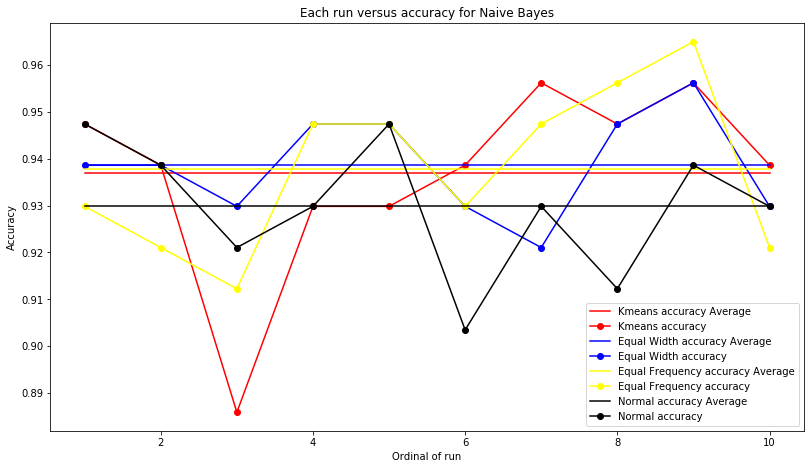

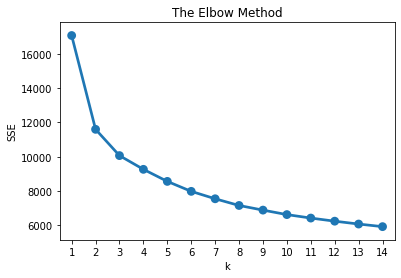

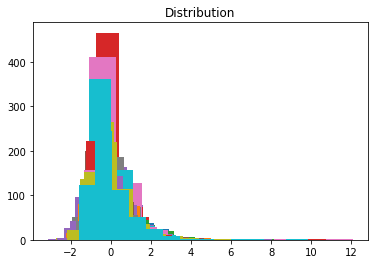

In [10]:
np.random.seed(420)
# Load wdbc.data dataset (numeric)
wdbc = pd.read_csv('wdbc.data', header = None)

# Get rid of ID number and standardlize the numeric data
wdbc = prework(wdbc, True, None, None, True)

# Generate the precision, recall, F-score and accuracy of Gaussian Naive Bayes and Naive Bayes 
# with discretizing by kmeans, equal width, and equal frequency at once
compare_accuracy(wdbc.iloc[:, 0:1], wdbc, pd.DataFrame())

# Show sse plot and distribution of numeric attrbutes
sse_distribution(wdbc)

Average precision of discretisation by kmeans, equal width, equal frequency and Gaussian naive Bayes are 0.95346453, 0.93768969, 0.94235077, 0.97179233.
Average recall of discretisation by kmeans, equal width, equal frequency and Gaussian naive Bayes are 0.96055004, 0.94448211, 0.94726624, 0.97022367.
Average F score of discretisation by kmeans, equal width, equal frequency and Gaussian naive Bayes are 0.95689127, 0.94100212, 0.94467707, 0.97098263.
Average accuracy of discretisation by kmeans, equal width, equal frequency and Gaussian naive Bayes are 0.95555556, 0.94166667 0.94444444 0.96944444.


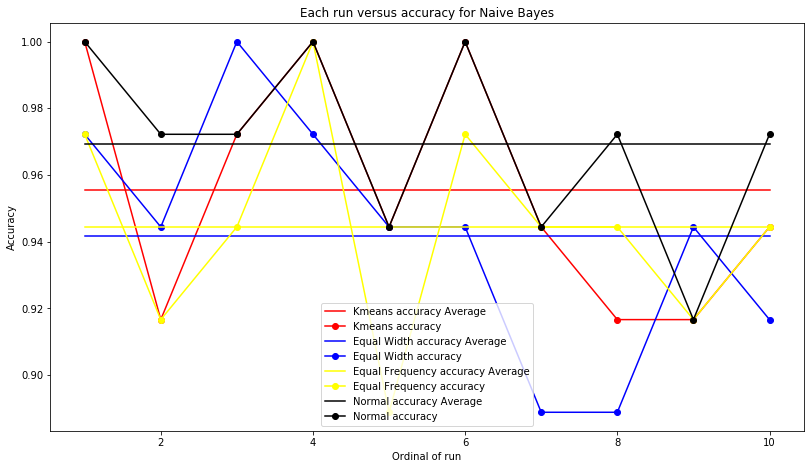

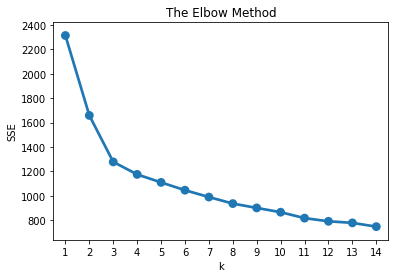

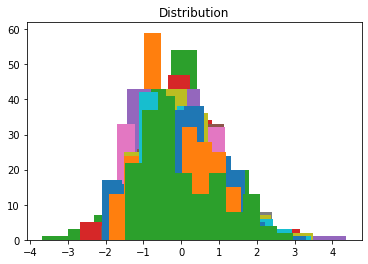

In [11]:
np.random.seed(420)
# Load wine.data dataset (numeric) 
wine = pd.read_csv('wine.data', header = None)

# Standardlize the numeric data
wine = prework(wine, False, None, None, True)

# Generate the precision, recall, F-score and accuracy of Gaussian Naive Bayes and Naive Bayes 
# with discretizing by kmeans, equal width, and equal frequency at once
compare_accuracy(wine.iloc[:, 0:1], wine, pd.DataFrame())

# Show sse plot and distribution of numeric attrbutes
sse_distribution(wine)

Average precision of discretisation by kmeans, equal width, equal frequency and Gaussian naive Bayes are 0.39200319, 0.32317221, 0.39072655, 0.32569740.
Average recall of discretisation by kmeans, equal width, equal frequency and Gaussian naive Bayes are 0.33555456, 0.29365422, 0.34900025, 0.27647558.
Average F score of discretisation by kmeans, equal width, equal frequency and Gaussian naive Bayes are 0.36004241, 0.30605174, 0.36795478, 0.29541236.
Average accuracy of discretisation by kmeans, equal width, equal frequency and Gaussian naive Bayes are 0.46666667, 0.45757576 0.46969697 0.43030303.


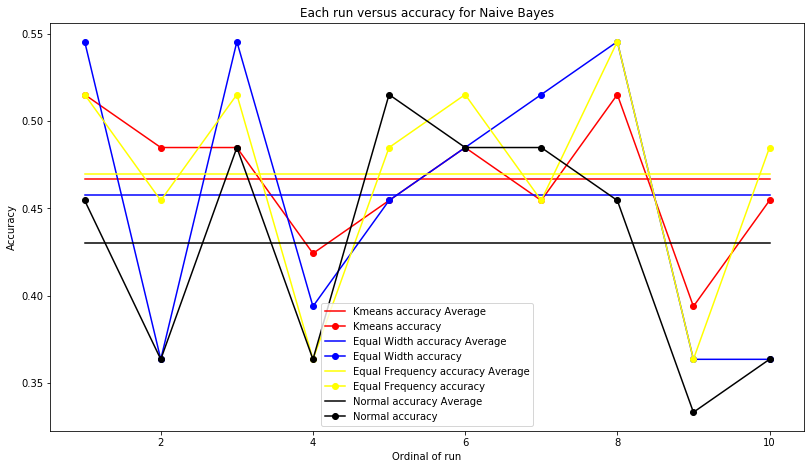

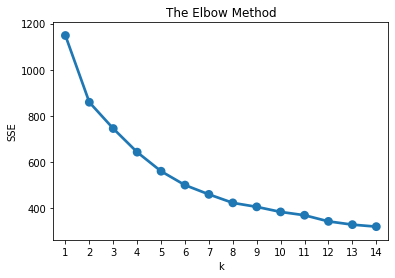

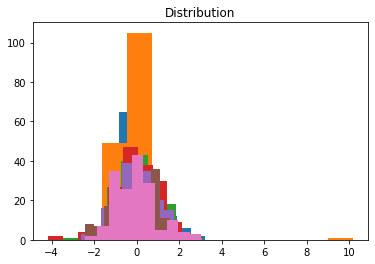

In [12]:
np.random.seed(420)
# Load university.data dataset (mix)
uni = pd.read_csv('university.data', header = None)

# Get rid of missing values and ID number
uni = prework(uni, True, ['0', 0], None, False)

# Make Class to the first column
uni_new = pd.DataFrame(uni.iloc[:, 13])

# Seperate the numeric variables and discrete variables then standardlize the numeric data
alreadyin = [13]
numeric = [3, 4 ,5 ,6 ,8, 10, 11]
# Create a dataframe with all numeric variables
for i in range(len(numeric)):
    uni_new = pd.concat([uni_new, uni.iloc[:, numeric[i]]], axis=1)
    alreadyin.append(numeric[i])
    
uni_new = prework(uni_new, False, None, None, True)

# Create a dataframe with all discrete variables
uni_left = pd.DataFrame()
for i in range(uni.shape[1]):
    if i not in alreadyin:
        uni_left = pd.concat([uni_left, pd.Series(list(uni.iloc[:, i]))], axis = 1)
uni_left = pd.concat([uni_new.iloc[:, 0:1], uni_left], axis = 1)

# Generate the precision, recall, F-score and accuracy of Gaussian Naive Bayes and Naive Bayes 
# with discretizing by kmeans, equal width, and equal frequency at once
compare_accuracy(uni_new.iloc[:, 0:1], uni_new, uni_left)

# Show sse plot and distribution of numeric attrbutes
sse_distribution(uni_new)

Average precision of discretisation by kmeans, equal width, equal frequency and Gaussian naive Bayes are 0.77173352, 0.74380681, 0.75933936, 0.77861953.
Average recall of discretisation by kmeans, equal width, equal frequency and Gaussian naive Bayes are 0.80514077, 0.76689138, 0.79143489, 0.73040500.
Average F score of discretisation by kmeans, equal width, equal frequency and Gaussian naive Bayes are 0.78801871, 0.75513439, 0.77502092, 0.75368922.
Average accuracy of discretisation by kmeans, equal width, equal frequency and Gaussian naive Bayes are 0.82675000, 0.80475000 0.81650000 0.82625000.


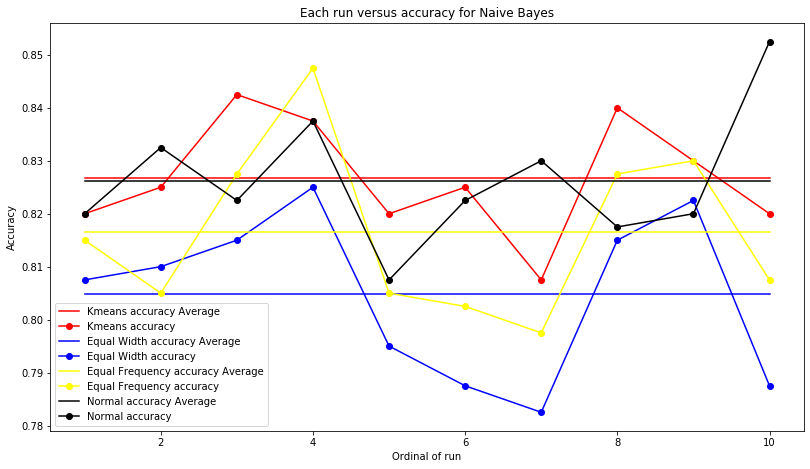

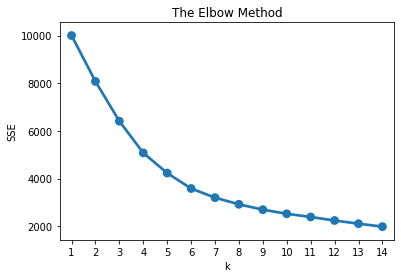

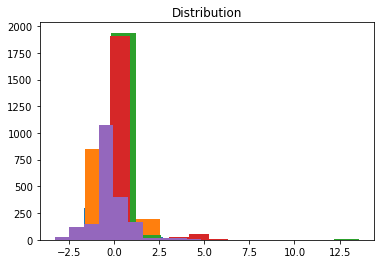

In [13]:
SAMPLE = 2000
np.random.seed(420)
# Load adult.data dataset (mix)
adult = pd.read_csv('adult.data', header = None)

# Get rid of missing values
adult = prework(adult, False, ['?'], None, False)

# As the dataset is too large to implement, randomly select 2000 instances for training and testing
select_num = list(np.random.choice(adult.shape[0], SAMPLE, replace = False))
select = pd.DataFrame()
for number in select_num:
    select[number] = adult.iloc[number,:]
adult = select.transpose()

# Make Class to the first column
adult_new = pd.DataFrame(adult.iloc[:,14])

# Seperate the numeric variables and discrete variables then standardlize the numeric data
alreadyin = [14]
numeric = [0, 2, 10, 11, 12]
# Create a dataframe with all numeric variables
for i in range(len(numeric)):
    adult_new = pd.concat([adult_new, adult.iloc[:, numeric[i]]], axis = 1)
    alreadyin.append(numeric[i])
adult_new = prework(adult_new, False, None, None, True)

# Create a dataframe with all discrete variables
adult_left = pd.DataFrame()
for i in range(adult.shape[1]):
    if i not in alreadyin:
        adult_left = pd.concat([adult_left, pd.Series(list(adult.iloc[:, i]))], axis = 1)
adult_left = pd.concat([adult_new.iloc[:, 0:1], adult_left], axis = 1)

# Generate the precision, recall, F-score and accuracy of Gaussian Naive Bayes and Naive Bayes 
# with discretizing by kmeans, equal width, and equal frequency at once
compare_accuracy(adult_new.iloc[:, 0:1], adult_new, adult_left)

# Show sse plot and distribution of numeric attrbutes
sse_distribution(adult_new)

Average precision of discretisation by kmeans, equal width, equal frequency and Gaussian naive Bayes are 0.70647159, 0.70850791, 0.66288004, 0.68121557.
Average recall of discretisation by kmeans, equal width, equal frequency and Gaussian naive Bayes are 0.62207876, 0.60863407, 0.61542521, 0.66259144.
Average F score of discretisation by kmeans, equal width, equal frequency and Gaussian naive Bayes are 0.66129730, 0.65436235, 0.63812951, 0.67160609.
Average accuracy of discretisation by kmeans, equal width, equal frequency and Gaussian naive Bayes are 0.87525000, 0.87600000 0.86175000 0.86375000.


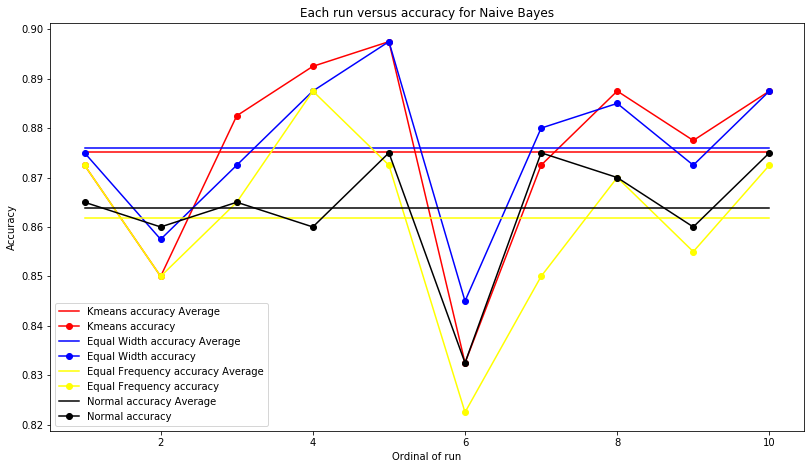

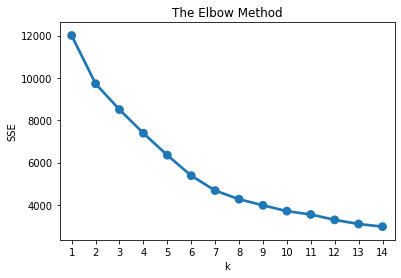

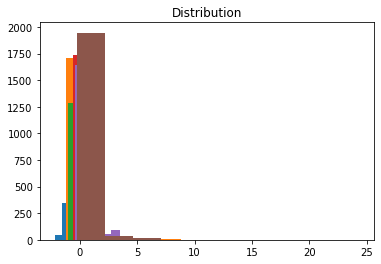

In [14]:
np.random.seed(420)
# Load bank.data dataset (mix)
bank = pd.read_csv('bank.data', header = None)

# As the dataset is too large to implement, randomly select 2000 instances for training and testing
select_num = list(np.random.choice(bank.shape[0], SAMPLE, replace = False))
select = pd.DataFrame()
for number in select_num:
    select[number] = bank.iloc[number,:]
bank = select.transpose()

# Make Class to the first column
bank_new = pd.DataFrame(bank.iloc[:,14])

# Seperate the numeric variables and discrete variables then standardlize the numeric data
alreadyin = [14]
numeric = [0, 5, 9, 10, 11, 12]
# Create a dataframe with all numeric variables
for i in range(len(numeric)):
    bank_new = pd.concat([bank_new, bank.iloc[:, numeric[i]]], axis=1)
    alreadyin.append(numeric[i])
bank_new = prework(bank_new, False, None, None, True)

# Create a dataframe with all discrete variables
bank_left = pd.DataFrame()
for i in range(bank.shape[1]):
    if i not in alreadyin:
        bank_left = pd.concat([bank_left, pd.Series(list(bank.iloc[:, i]))], axis=1)
bank_left = pd.concat([bank_new.iloc[:, 0:1], bank_left], axis=1)

# Generate the precision, recall, F-score and accuracy of Gaussian Naive Bayes and Naive Bayes 
# with discretizing by kmeans, equal width, and equal frequency at once
compare_accuracy(bank_new.iloc[:, 0:1], bank_new, bank_left)

# Show sse plot and distribution of numeric attrbutes
sse_distribution(bank_new)

### Q2
Implement a baseline model (e.g., random or 0R) and compare the performance of the na¨ıve Bayes classifier to this baseline on multiple datasets. Discuss why the baseline performance varies across datasets, and to what extent the na¨ıve Bayes classifier improves on the baseline performance.

### Q3
Since it’s difficult to model the probabilities of ordinal data, ordinal attributes are often treated as either nominal variables or numeric variables. Compare these strategies on the ordinal datasets provided. Deterimine which approach gives higher classification accuracy and discuss why.

### Q4
Evaluating the model on the same data that we use to train the model is considered to be a major mistake in Machine Learning. Implement a hold–out or cross–validation evaluation strategy (you should implement this yourself and do not simply call existing implementations from `scikit-learn`). How does your estimate of effectiveness change, compared to testing on the training data? Explain why. (The result might surprise you!)

### Q5
Implement one of the advanced smoothing regimes (add-k, Good-Turing). Does changing the smoothing regime (or indeed, not smoothing at all) affect the effectiveness of the na¨ıve Bayes classifier? Explain why, or why not.

In [15]:
# Find the accuracy list for different add-k
def combine(file_name, k_value):
    
    # Initialize number of category counts that have not appeared in training dataset but appeard in testing data
    count = 0
    # Random generate training dataset and testing dataset
    x_train_number = list(np.random.choice(file_name.shape[0], int(file_name.shape[0] * 0.8), replace = False))
    x_train_ = find_train(file_name, x_train_number)
    x_test_ = find_test(file_name, x_train_number)
    
    # Construct the dictionary to store the number of each group (label) in the training dataset
    class_dict_ = defaultdict(int)
    for element in x_train_.iloc[:,0]:
        class_dict_[element] += 1    
    
    # Train the dataset that construct the dictionary to store under each label, for each specific 
    # attribute, the number of each group    
    class_dict_final = train(x_train_, class_dict_, 'discrete')
    
    # Find the number of category counts that have not appeared in training dataset before but appeared in 
    # testing dataset
    for i in range(1, file_name.shape[1]):
        for j in range(x_test_.shape[0]):
            label = x_test_.iloc[j, 0]
            if x_test_.iloc[j, i] not in class_dict_final[i][label].keys():
                count += 1
    
    # Find the accuracy for add-k smoothing method when k = k
    label_predict = predict(x_test_.iloc[:, 0:1], pd.DataFrame(), x_test_.iloc[:, 1:], class_dict_, 
                                {}, class_dict_final, k_value)
    accuracy = evaluate(list(x_test_.iloc[:, 0]), label_predict)
    return accuracy[0], count

In [16]:
# Plot the boost graph
def boost_plot(boost_list):
    
    # Find standard line when k = 0 (no smoothing)
    standard_boost = []
    for j in range(20):
        standard_boost.append(boost_list[0])
    
    # Plot the graph for different k (0 < k <= 1, smoothing compared to no smoothing)
    plt.plot(list(np.arange(0.05, 1.05, 0.05)), boost_list[1:], marker = 'o', label = f'Number of boost' )
    plt.plot(list(np.arange(0.05, 1.05, 0.05)), standard_boost, label = f'Standard Boost (k = 0)' )
    plt.legend()
    plt.title('k-value versus number of boost')
    plt.xlabel('k-value')
    plt.ylabel('number of boost')
    plt.show()   

In [17]:
# Plot the average accuracy graph
def accuracy_plot(average_list):
    
    # Find standard line when k = 0 (no smoothing)
    standard_average = []
    for j in range(20):
        standard_average.append(average_list[0])
    
    # Plot the graph for different k (0 < k <= 1, smoothing compared to no smoothing)
    plt.plot(list(np.arange(0.05, 1.05, 0.05)), average_list[1:], marker = 'o', label = f'Average accuracy for k' )
    plt.plot(list(np.arange(0.05, 1.05, 0.05)), standard_average, label = f'Standard Average (k = 0)' )

    plt.legend()
    plt.title('k-value versus average accuracy')
    plt.xlabel('k-value')
    plt.ylabel('Accuracy')
    plt.show()   

In [18]:
# Calculate the number of boost and average accuracy for different k
NO_K = 0
def average_boost(file_name):
    # Intialize the lists
    accuracy_list = []
    average_list = []
    boost_list = []
    appear = 0
    
    # Initialize number of boost and average accuracy when k = 0 (no smoothing)
    for i in range(REPEAT):
        temp = combine(file_name, NO_K)
        accuracy_list.append(temp[0])
        appear += temp[1]
    boost_list.append(5.5)
    average_list.append(sum(accuracy_list) / REPEAT)
    
    # Calculate the number of boost and average accuracy for k from 0.05 to 1 (inclusive) with interval 0.05
    # Calculate total number of category counts that have not appeared in training data 
    # but appeared in testing data
    for k in list(np.arange(0.05, 1.05, 0.05)):
        accuracy_list = []
        boost = 0
        for i in range(REPEAT):
            temp = combine(file_name, k)
            if temp[0] > average_list[0]:
                boost += 1
            accuracy_list.append(temp[0])
            appear += temp[1]
        boost_list.append(boost)
        average_list.append(sum(accuracy_list) / REPEAT)
    
    # Plot the boost graph and average accuracy plot
    boost_plot(boost_list)
    accuracy_plot(average_list)
    return (appear / (REPEAT * (1.05 / 0.05)))

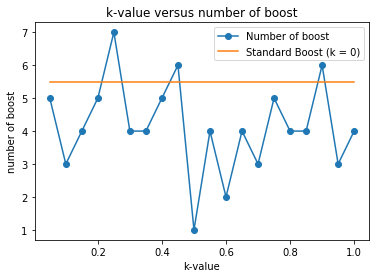

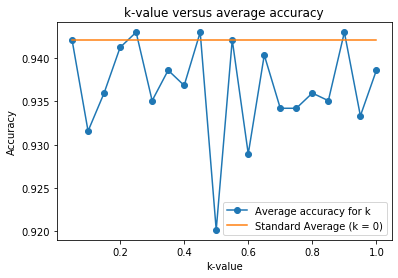

Number of category counts appeared in testing data but haven’t appeared in training data per testing trial is 1.17619048.


In [20]:
# wdbc dataset add-k smoothing (continuous variables to discrete variables by discretizing with kmeans)
np.random.seed(1000)
wdbc = pd.read_csv('wdbc.data', header = None)

# Get rid of ID number and standardlize the numeric data
# Constructe new dataset by discretizing the varibles with K-mean method
k_means_wdbc = prework(wdbc, True, None, 'kmeans', True)

# Plot the boost graph and average accuracy plot
print(f'Number of category counts appeared in testing data but haven’t appeared in training data '
      f'per testing trial is {average_boost(k_means_wdbc):0.8f}.')

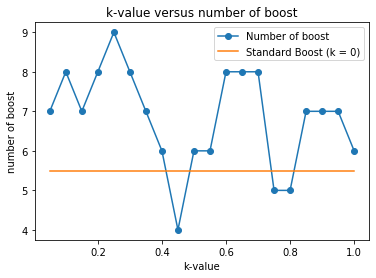

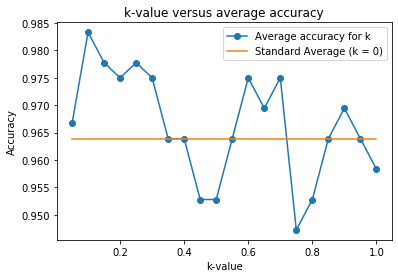

Number of category counts appeared in testing data but haven’t appeared in training data per testing trial is 1.77142857.


In [21]:
# wine dataset add-k smoothing (continuous variables to discrete variables by discretizing with kmeans)
np.random.seed(1000)
wine = pd.read_csv('wine.data', header = None)

# Standardlize the numeric data and constructe new dataset by discretizing the varibles with K-mean method
k_means_wine = prework(wine, False, None, 'kmeans', True)

# Plot the boost graph and average accuracy plot
print(f'Number of category counts appeared in testing data but haven’t appeared in training data '
      f'per testing trial is {average_boost(k_means_wine):0.8f}.')

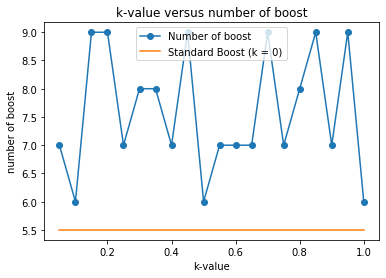

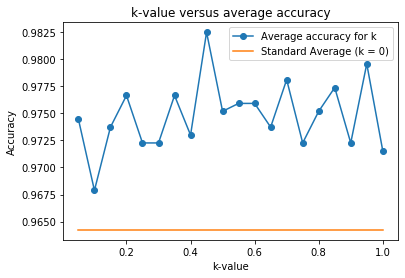

Number of category counts appeared in testing data but haven’t appeared in training data per testing trial is 4.20952381.


In [22]:
# breast dataset add-k smoothing (nominal variables)
np.random.seed(1000)
breast = pd.read_csv('breast-cancer-wisconsin.data', header = None)

# Get rid of missing values and ID number
breast = prework(breast, True, ['?'], None, False)

# Make Class to the first column
breast_new = pd.DataFrame(breast.iloc[:, 9])
for i in range(1, 10):
    breast_new[i] = breast.iloc[:,i - 1]
    
# Plot the boost graph and average accuracy plot
print(f'Number of category counts appeared in testing data but haven’t appeared in training data '
      f'per testing trial is {average_boost(breast_new):0.8f}.')

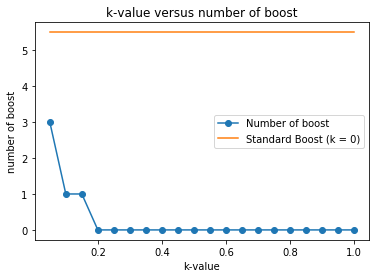

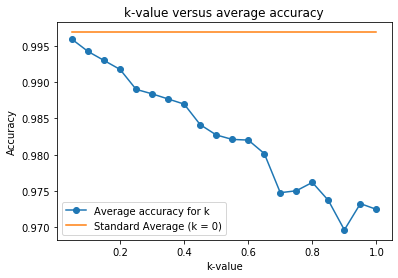

Number of category counts appeared in testing data but haven’t appeared in training data per testing trial is 0.01904762.


In [23]:
# mushroom dataset add-k smoothing (nominal variables)
np.random.seed(1000)
mushroom = pd.read_csv('mushroom.data', header = None)

# Get rid of missing values
mushroom = prework(mushroom, False, ['?'], None, False)

# Plot the boost graph and average accuracy plot
print(f'Number of category counts appeared in testing data but haven’t appeared in training data '
      f'per testing trial is {average_boost(mushroom):0.8f}.')

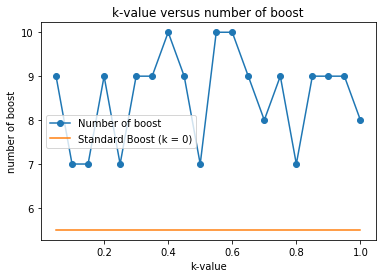

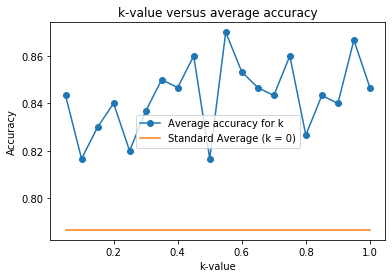

Number of category counts appeared in testing data but haven’t appeared in training data per testing trial is 9.05714286.


In [24]:
# lymphography dataset add-k smoothing (nominal variables)
np.random.seed(1000)
lymphography = pd.read_csv('lymphography.data', header = None)

# Plot the boost graph and average accuracy plot
print(f'Number of category counts appeared in testing data but haven’t appeared in training data '
      f'per testing trial is {average_boost(lymphography):0.8f}.')

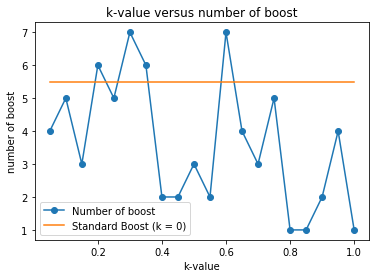

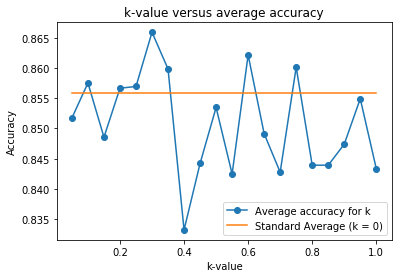

Number of category counts appeared in testing data but haven’t appeared in training data per testing trial is 0.00000000.


In [25]:
# car dataset add-k smoothing (ordinal variables treated as nominal variables)
np.random.seed(1000)
car = pd.read_csv('car.data', header = None)

# Convert class column to the first column
car_new = pd.DataFrame(car.iloc[:,6])
for i in range(6):
    car_new[i] = car.iloc[:,i]
    
# Plot the boost graph and average accuracy plot
print(f'Number of category counts appeared in testing data but haven’t appeared in training data '
      f'per testing trial is {average_boost(car_new):0.8f}.')

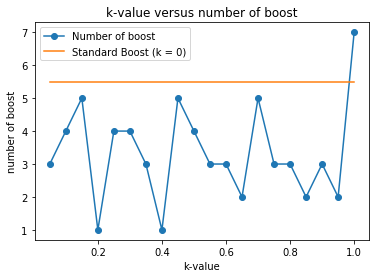

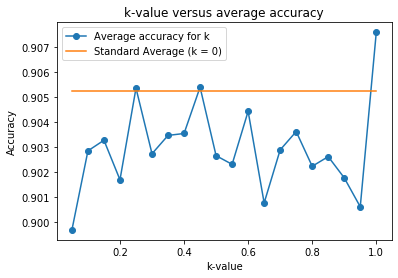

Number of category counts appeared in testing data but haven’t appeared in training data per testing trial is 1.32380952.


In [26]:
# nursery dataset add-k smoothing (ordinal variables treated as nominal variables)
np.random.seed(1000)
nursery = pd.read_csv('nursery.data', header = None)

# Convert class column to the first column
nursery_new = pd.DataFrame(nursery.iloc[:,8])
for i in range(8):
    nursery_new[i] = nursery.iloc[:,i]
    
# Plot the boost graph and average accuracy plot
print(f'Number of category counts appeared in testing data but haven’t appeared in training data '
      f'per testing trial is {average_boost(nursery_new):0.8f}.')

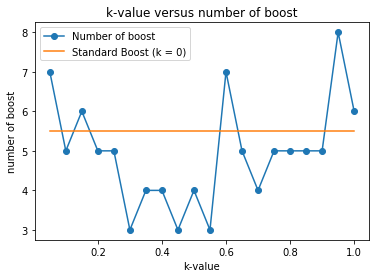

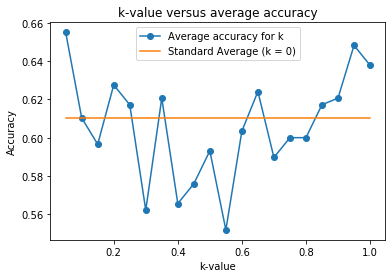

Number of category counts appeared in testing data but haven’t appeared in training data per testing trial is 1.45714286.


In [27]:
# somerville dataset add-k smoothing (nominal)
np.random.seed(1000)
somerville = pd.read_csv('somerville.data', header = None)

# Plot the boost graph and average accuracy plot
print(f'Number of category counts appeared in testing data but haven’t appeared in training data '
      f'per testing trial is {average_boost(somerville):0.8f}.')

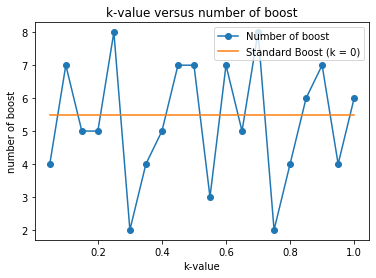

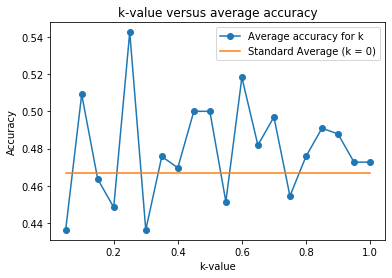

Number of category counts appeared in testing data but haven’t appeared in training data per testing trial is 27.23809524.


In [28]:
# university dataset add-k smoothing (mix)
np.random.seed(1000)

# Convert the numeric part to discrete by discretizing the varibles with K-mean method
k_means_uni = prework(uni_new, False, None, 'kmeans', False)
# Combine two discrete parts to get the new dataset
uni_discrete = pd.concat([k_means_uni, uni_left.iloc[:, 1:]], axis=1)

# Plot the boost graph and average accuracy plot
print(f'Number of category counts appeared in testing data but haven’t appeared in training data '
      f'per testing trial is {average_boost(uni_discrete):0.8f}.')

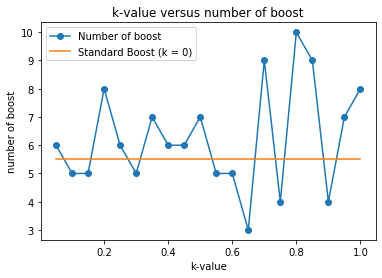

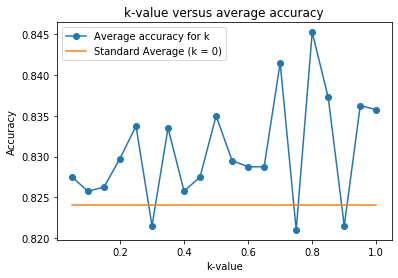

Number of category counts appeared in testing data but haven’t appeared in training data per testing trial is 8.27619048.


In [29]:
# adult dataset add-k smoothing (mix)
np.random.seed(1000)

# Convert the numeric part to discrete by discretizing the varibles with K-mean method
k_means_adult = prework(adult_new, False, None, 'kmeans', False)
# Combine two discrete parts to get the new dataset
adult_discrete = pd.concat([k_means_adult, adult_left.iloc[:, 1:]], axis=1)

# Plot the boost graph and average accuracy plot
print(f'Number of category counts appeared in testing data but haven’t appeared in training data '
      f'per testing trial is {average_boost(adult_discrete):0.8f}.')

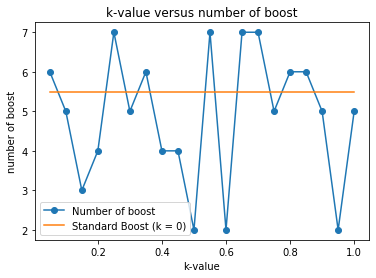

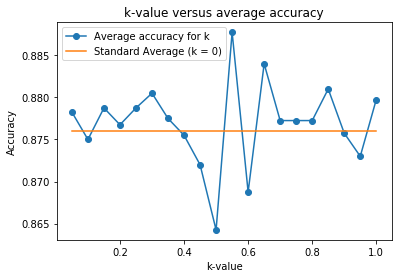

Number of category counts appeared in testing data but haven’t appeared in training data per testing trial is 0.67619048.


In [30]:
# bank dataset add-k smoothing (mix)
np.random.seed(1000)

# Convert the numeric part to discrete by discretizing the varibles with K-mean method
k_means_bank = prework(bank_new, False, None, 'kmeans', False)
# Combine two discrete parts to get the new dataset
bank_discrete = pd.concat([k_means_bank, bank_left.iloc[:, 1:]], axis=1)

# Plot the boost graph and average accuracy plot
print(f'Number of category counts appeared in testing data but haven’t appeared in training data '
      f'per testing trial is {average_boost(bank_discrete):0.8f}.')

### Q6
The Gaussian na¨ıve Bayes classifier assumes that numeric attributes come from a Gaussian distribution. Is this assumption always true for the numeric attributes in these datasets? Identify some cases where the Gaussian assumption is violated and describe any evidence (or lack thereof) that this has some effect on the NB classifier’s predictions.